# testing models from CMIP6 historical runs
This script opens up CMIP6 historical model run files with data on precipitation pr and surface temperature tas and calculates monthly anomalies for each region.  Then tests the models for each region.  


In [1]:
import xarray as xr, matplotlib.pyplot as plt
#import sys 
#sys.path.append('') # use this if the function file is in a different directory to the notebook
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load

In [2]:
# import custom functions
import anomaly_function as func # imports the function
import model_figures as func2

In [3]:
# use this to reload the function file if I make any edits to it
func = reload(func) 
func2 = reload(func2)

In [4]:
!ls /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/pr/gr1.5

v20200302


In [5]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
print(institution_dir, tas_dir, pr_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/


## Read in model data

In [6]:
models_tas = func.read_models(institution_dir, tas_dir, '1850-01','2015-01')

46 model paths found and loaded into the dictionary "models"
MPI-ESM-1-2-HAM /g/data/lp01/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ESM-1-2-HAM/historical/r1i1p1f1/Amon/tas/gr1.5/v20190627/*.nc
NESM3 /g/data/lp01/CMIP6/CMIP/NUIST/NESM3/historical/r1i1p1f1/Amon/tas/gr1.5/v20190630/*.nc
Path for MCM-UA-1-0 does not exist
ACCESS-CM2 /g/data/lp01/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/tas/gr1.5/v20190919/*.nc
Model MPI-ESM1-2-HR has different time so is now removed
MPI-ESM1-2-LR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/Amon/tas/gr1.5/v20190710/*.nc
IPSL-CM6A-LR /g/data/lp01/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/tas/gr1.5/v20180803/*.nc
CAS-ESM2-0 /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/tas/gr1.5/v20200302/*.nc
FGOALS-f3-L /g/data/lp01/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/r1i1p1f1/Amon/tas/gr1.5/v20190927/*.nc
FGOALS-g3 /g/data/lp01/CMIP6/CMIP/CAS/FGOALS-g3/historical/r1i1p1f1/Amon/tas/gr1.5/v20190818/*.nc
BCC-ESM1 

In [7]:
models_pr = func.read_models(institution_dir, pr_dir, '1850-01','2015-01')

45 model paths found and loaded into the dictionary "models"
MPI-ESM-1-2-HAM /g/data/lp01/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ESM-1-2-HAM/historical/r1i1p1f1/Amon/pr/gr1.5/v20190627/*.nc
NESM3 /g/data/lp01/CMIP6/CMIP/NUIST/NESM3/historical/r1i1p1f1/Amon/pr/gr1.5/v20190630/*.nc
Path for MCM-UA-1-0 does not exist
ACCESS-CM2 /g/data/lp01/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/pr/gr1.5/v20190919/*.nc
MPI-ESM1-2-HR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/Amon/pr/gr1.5/v20190710/*.nc
MPI-ESM1-2-LR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/Amon/pr/gr1.5/v20190710/*.nc
IPSL-CM6A-LR /g/data/lp01/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/pr/gr1.5/v20180803/*.nc
CAS-ESM2-0 /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/pr/gr1.5/v20200302/*.nc
FGOALS-f3-L /g/data/lp01/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/r1i1p1f1/Amon/pr/gr1.5/v20190927/*.nc
FGOALS-g3 /g/data/lp01/CMIP6/CMIP/CAS/FGOALS-g3/historical/r1i1p

In [8]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.where(models_tas.model.isin(models_pr.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_tas.model), drop = True)
#chekc that the models are the same for both variables and if so print True
models_tas.model.equals(models_pr.model)

True

In [9]:
# combine precipitation and temperature into one dataset
models = xr.Dataset({'tas': models_tas.tas, 'pr': models_pr.pr})
# change the pr units
models['pr'] = models.pr*86400
models

,Array,Chunk
Bytes,9.35 GB,1.38 MB
Shape,"(41, 1980, 120, 240)","(1, 12, 120, 240)"
Count,34445 Tasks,6765 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,18.70 GB,2.76 MB
Shape,"(41, 1980, 120, 240)","(1, 12, 120, 240)"
Count,42202 Tasks,6765 Chunks
Type,float64,numpy.ndarray


In [10]:
# get rid of models with issues
models = models.drop_sel(model=['CIESM'])

In [11]:
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 40 models will be used in all subsequent calculations: 

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CMCC-CM2-SR5' 'CanESM5' 'E3SM-1-1'
 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'FGOALS-g3'
 'FIO-ESM-2-0' 'GFDL-CM4' 'GFDL-ESM4' 'GISS-E2-1-G' 'GISS-E2-1-G-CC'
 'GISS-E2-1-H' 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G'
 'MIROC6' 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1'
 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1']


## select out time around krakatoa eruption
I need to select out the time around each eruption or at least store each eruption in a separate array so that I don't get a "minimum" for one eruption in 1891 and the next in 1991

In [12]:
models = models.sel(time = slice('1850-01','1900-01'))

In [13]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

In [14]:
# save arrays of times relative to each eruption
e_pre5yrs = e_date - 60 * pd.offsets.MonthBegin()
e_pre3mon = e_date - 3 * pd.offsets.MonthBegin()
e_post5yrs = e_date + 61 * pd.offsets.MonthBegin()
e_post10yrs = e_date + 121 * pd.offsets.MonthBegin()

## Select out regions
Right now I have all the models stored in one array so from hereafter I can calculate anomalies etc.  

In [15]:
# area weighting 
models_w = models*np.cos(models_tas.lat*(np.pi/180))

In [16]:
# import land fraction data
landfrac_ds = xr.open_dataset('/home/563/kb6999/Models/landfraction_file_grid1.5.nc')
landmask = landfrac_ds.mean(dim='time')

## Anomalies

In [17]:
# use functions to calculate the monthly anomalies for the globe
mon_anom_Glob = func.monthly_anomaly(models_w, '1850-01', '1881-01')

In [18]:
# select out regions for other anomalies 
mon_anom_SH = mon_anom_Glob.sel(lat=slice(-90,0)) 
mon_anom_NH = mon_anom_Glob.sel(lat=slice(0,90)) 
mon_anom_Aus = mon_anom_Glob.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.data==1, drop=True)
mon_anom_EA = mon_anom_Glob.sel(lat=slice(-50,-10), lon=slice(140,155)).where(landmask.data==1, drop=True)

In [19]:
mean_mon_Glob = mon_anom_Glob.mean(dim = ['lat','lon'])
mean_mon_SH = mon_anom_SH.mean(dim = ['lat','lon'])
mean_mon_Aus = mon_anom_Aus.mean(dim = ['lat','lon'])
mean_mon_EA = mon_anom_EA.mean(dim = ['lat','lon'])

In [20]:
# calculate the standard deviation for each model over the time period from 1850-1880
std_Glob = mean_mon_Glob.sel(time = slice('1850-01', '1881-01')).std(dim = ['time'])
std_SH = mean_mon_SH.sel(time = slice('1850-01', '1881-01')).std(dim = ['time'])
std_Aus = mean_mon_Aus.sel(time = slice('1850-01', '1881-01')).std(dim = ['time'])
std_EA = mean_mon_EA.sel(time = slice('1850-01', '1881-01')).std(dim = ['time'])

In [21]:
# calculate the mean for each model over the time period from 1850-1880
time_mean_Glob = mean_mon_Glob.sel(time = slice('1850-01', '1881-01')).mean(dim = ['time'])
time_mean_SH = mean_mon_SH.sel(time = slice('1850-01', '1881-01')).mean(dim = ['time'])
time_mean_Aus = mean_mon_Aus.sel(time = slice('1850-01', '1881-01')).mean(dim = ['time'])
time_mean_EA = mean_mon_EA.sel(time = slice('1850-01', '1881-01')).mean(dim = ['time'])

# Count below threshold for each model
First select only the values below our threshold, then get the count of unmasked values along the time dimension


# need to test if i have to take the lat lon mean before calculating std
## and need to test if my threhold formula is:
mean_mon_Glob < time_mean_Glob - 2*std_Glob OR

mean_ANOM_Glob < time_mean_Glob - 2*std_Glob

In [22]:
# check if the anomalies are less than the 2 standard deviation 
model_2std_count_Glob = mean_mon_Glob.where(mean_mon_Glob < time_mean_Glob - 2*std_Glob).count('time')
model_2std_count_SH = mean_mon_SH.where(mean_mon_SH < time_mean_SH - 2*std_SH).count('time')
model_2std_count_Aus = mean_mon_Aus.where(mean_mon_Aus < time_mean_Aus - 2*std_Aus).count('time')
model_2std_count_EA = mean_mon_EA.where(mean_mon_EA < time_mean_EA - 2*std_EA).count('time')

In [23]:
# check if the anomalies are less than the 3 standard deviation 
model_3std_count_Glob = mean_mon_Glob.where(mean_mon_Glob < time_mean_Glob - 3*std_Glob).count('time')
model_3std_count_SH = mean_mon_SH.where(mean_mon_SH < time_mean_SH - 3*std_SH).count('time')
model_3std_count_Aus = mean_mon_Aus.where(mean_mon_Aus < time_mean_Aus - 3*std_Aus).count('time')
model_3std_count_EA = mean_mon_EA.where(mean_mon_EA < time_mean_EA - 3*std_EA).count('time')

condition = mean_mon_Glob < time_mean_Glob - std_Glob

## Minimum values for each model
The same idea, this time using 'min' instead of 'count'

In [24]:
model_std_min_Glob = mean_mon_Glob.where(mean_mon_Glob < time_mean_Glob - std_Glob).min('time')
model_std_min_SH = mean_mon_SH.where(mean_mon_SH < time_mean_SH - std_SH).min('time')
model_std_min_Aus = mean_mon_Aus.where(mean_mon_Aus < time_mean_Aus - std_Aus).min('time')
model_std_min_EA = mean_mon_EA.where(mean_mon_EA < time_mean_EA - std_EA).min('time')

In [25]:
model_2std_min_Glob = mean_mon_Glob.where(mean_mon_Glob < time_mean_Glob - 2*std_Glob).min('time')
model_2std_min_SH = mean_mon_SH.where(mean_mon_SH < time_mean_SH - 2*std_SH).min('time')
model_2std_min_Aus = mean_mon_Aus.where(mean_mon_Aus < time_mean_Aus - 2*std_Aus).min('time')
model_2std_min_EA = mean_mon_EA.where(mean_mon_EA < time_mean_EA - 2*std_EA).min('time')

In [26]:
model_std_min_Glob

<xarray.Dataset>
Dimensions:  (model: 40)
Coordinates:
  * model    (model) <U16 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'TaiESM1'
Data variables:
    tas      (model) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    pr       (model) float64 dask.array<chunksize=(1,), meta=np.ndarray>

## Date of minimum value for each model¶
Start off by finding the index of the minimum value - argmin.

In [27]:
min_index_Glob = mean_mon_Glob.where(mean_mon_Glob < time_mean_Glob - std_Glob).argmin('time')
min_index_SH = mean_mon_SH.where(mean_mon_SH < time_mean_SH - std_SH).argmin('time')
min_index_Aus = mean_mon_Aus.where(mean_mon_Aus < time_mean_Aus - std_Aus).argmin('time')
min_index_EA = mean_mon_EA.where(mean_mon_EA < time_mean_EA - std_EA).argmin('time')

In [28]:
min_index2_Glob = mean_mon_Glob.where(mean_mon_Glob < time_mean_Glob - 2*std_Glob).argmin('time')
min_index2_SH = mean_mon_SH.where(mean_mon_SH < time_mean_SH - 2*std_SH).argmin('time')
min_index2_Aus = mean_mon_Aus.where(mean_mon_Aus < time_mean_Aus - 2*std_Aus).argmin('time')
min_index2_EA = mean_mon_EA.where(mean_mon_EA < time_mean_EA - 2*std_EA).argmin('time')

These indices can be converted to time values all at once by using min_index as an array index

There's a "ghost" time axis in the result which might cause problems, let's get rid of it. Our returned values aren't time dependent

In [29]:
min_time2_Glob_pr = mean_mon_Glob.pr.time[min_index2_Glob.pr].drop('time').drop('month')
min_time2_Glob_tas = mean_mon_Glob.tas.time[min_index2_Glob.tas].drop('time').drop('month')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/dask/array/reductions.py:904: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/dask/array/reductions.py:904: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/dask/array/reductions.py:904: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/dask/array/reductions.py:904: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/dask/array/reductions.py:904: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_a

In [30]:
min_time_Glob_pr = mean_mon_Glob.pr.time[min_index_Glob.pr].drop('time').drop('month')
min_time_Glob_tas = mean_mon_Glob.tas.time[min_index_Glob.tas].drop('time').drop('month')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/dask/array/reductions.py:904: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/dask/array/reductions.py:904: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/dask/array/reductions.py:904: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/dask/array/reductions.py:904: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/dask/array/reductions.py:904: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_a

It could be helpful to put all of the results into a single dataset

In [31]:
event_stats_pr_Glob = xr.Dataset({
    'count': model_2std_count_Glob.pr,
    'min': model_2std_min_Glob.pr,
    'min_date': min_time2_Glob_pr,
})

event_stats_pr_Glob



<xarray.Dataset>
Dimensions:   (model: 40)
Coordinates:
  * model     (model) <U16 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'TaiESM1'
Data variables:
    count     (model) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    min       (model) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    min_date  (model) datetime64[ns] 1887-01-31 1887-02-28 ... 1885-06-30

In [32]:
event_stats_tas_Glob = xr.Dataset({
    'count': model_2std_count_Glob.tas,
    'min': model_2std_min_Glob.tas,
    'min_date': min_time2_Glob_tas,
})

## perhaps try and add in the multimodel mean here too so it's also included in hte table 
or actually add in the mmm earlier so that i do all the calculations for it 

In [92]:
event_stats_tas_Glob_df = event_stats_pr_Glob.to_dataframe()
event_stats_tas_Glob_df

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


,count,min,min_date
model,,,
ACCESS-CM2,30,-0.062154,1887-01-31
ACCESS-ESM1-5,23,-0.052239,1887-02-28
AWI-CM-1-1-MR,19,-0.059788,1892-04-30
AWI-ESM-1-1-LR,34,-0.055855,1884-10-31
BCC-CSM2-MR,18,-0.057399,1863-03-31
BCC-ESM1,24,-0.050033,1890-02-28
CAMS-CSM1-0,16,-0.065772,1890-02-28
CAS-ESM2-0,25,-0.060345,1893-03-31
CESM2,24,-0.056107,1868-09-30


In [93]:
event_stats_pr_Glob_df = event_stats_pr_Glob.to_dataframe()
event_stats_pr_Glob_df

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


,count,min,min_date
model,,,
ACCESS-CM2,30,-0.062154,1887-01-31
ACCESS-ESM1-5,23,-0.052239,1887-02-28
AWI-CM-1-1-MR,19,-0.059788,1892-04-30
AWI-ESM-1-1-LR,34,-0.055855,1884-10-31
BCC-CSM2-MR,18,-0.057399,1863-03-31
BCC-ESM1,24,-0.050033,1890-02-28
CAMS-CSM1-0,16,-0.065772,1890-02-28
CAS-ESM2-0,25,-0.060345,1893-03-31
CESM2,24,-0.056107,1868-09-30


In [65]:
dataset = composite

In [66]:
# set the data for rows and columns 
rows = dataset.model.data
cols = dataset.stats.data

In [72]:
cols

array(['count', 'min'], dtype='<U5')

In [73]:
# convert to data array (rather than xarray)
ds = dataset.values

# change the axes so that rows correspond to each model and cols correspond to volcanoes
ds = np.swapaxes(ds,0,1)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


In [81]:
dataset.stats.data

array(['count', 'min'], dtype='<U5')

ValueError: 'rowLabels' must be of length 3

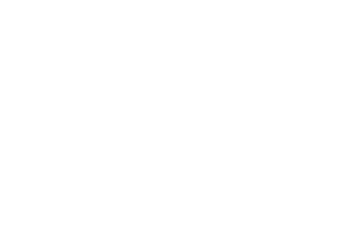

In [94]:
fig, ax = plt.subplots()
# make table
ax.axis('off')
tab = ax.table(cellText = ds, colLabels=cols, rowLabels=rows, loc='upper center',cellLoc='center')

tab.set_fontsize(14)


In [33]:
# event_stats = xarray.Dataset({
#     'count': da.where(da < 0).count('time'),
#     'min': da.where(da < 0).min('time'),
#     'min_date': da.time[min_index].drop('time'),
# })

# event_stats

NameError: name 'xarray' is not defined

## Climtas event detection
The climtas library has some functions for event detection - it will find runs where a condition is true for multiple times, then let you run a function to calculate statistics for each event

In [ ]:
mean_mon_Glob < time_mean_Glob - 2*std_Glob

In [90]:
import climtas

events = climtas.event.find_events(mean_mon_Glob.pr < 0, min_duration=2)
events

AttributeError: 'Array' object has no attribute 'take'

In [34]:
import climtas

events = climtas.event.find_events(mean_mon_Glob.pr < time_mean_Glob.pr - std_Glob.pr, min_duration=2)
events

AttributeError: 'Array' object has no attribute 'take'

In [ ]:
coords = climtas.event.event_coords(mean_mon_Glob.pr, events)

def stat_func(event_data):
    return {'min': event_data.min().values,
            'min_date': event_data.time[event_data.argmin()].values}
    
minimum = climtas.event.map_events(da, events, stat_func)

coords.join(minimum)

## .where function
There are two kinds of .where().  dataset.where() is used for masking on a dataarray, while the top level xr.where(condition, option1, option2) chooses between 2 values.  

## Model test 
Check to see which models have a cooling signal 

## Figures

In [ ]:
# eruption date
e_date = ['1883-08','1902-10', '1963-03', '1982-04', '1991-06']
e_pre5yrs = ['1878-08','1897-10', '1958-03', '1977-04', '1986-06']
e_pre3mon = ['1883-05','1902-7', '1962-12', '1982-01', '1991-03']
e_post5yrs = ['1888-08','1907-10', '1968-03', '1987-04', '1996-06']
e_post10yrs = ['1893-08','1912-10', '1973-03', '1992-04', '2001-06']